In [30]:
import cv2
import json
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

In [8]:
# Set output area size for image
plt.rcParams['figure.figsize'] = (15.0, 15.0)

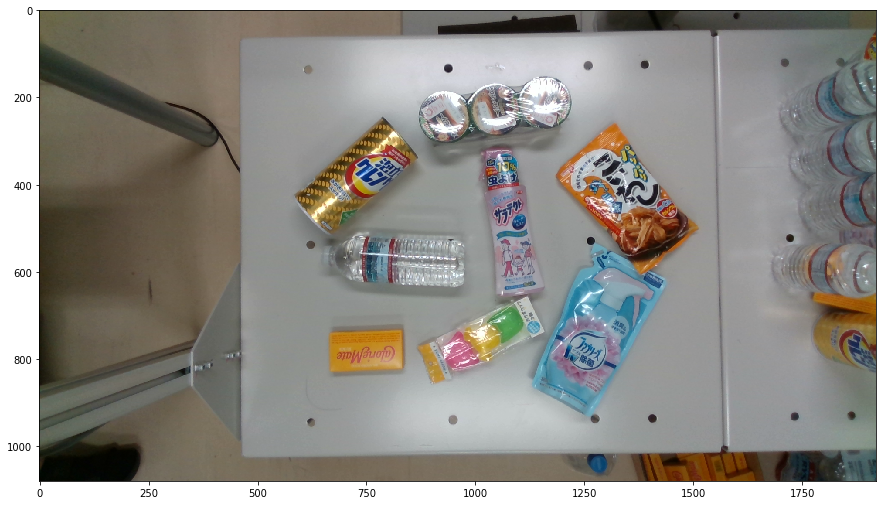

In [51]:
img = cv2.imread("test.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

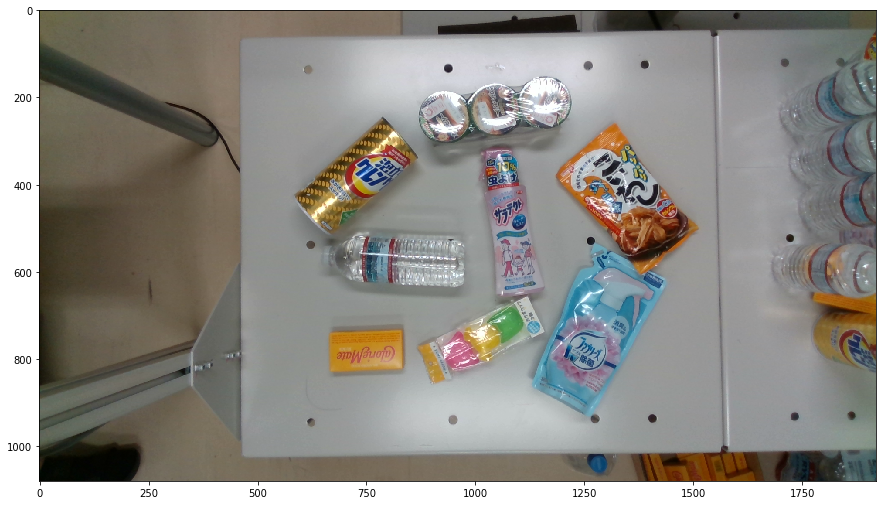

In [26]:
#aug = iaa.CropToFixedSize(width=1080, height=1080, position="center")
#aug = iaa.Affine(rotate=(-180, 180))
#aug = iaa.Sometimes(0.8, iaa.Affine(rotate=(-180, 180)))
#img = aug.augment_image(img)
plt.imshow(img)
plt.show()

In [83]:
annotations = json.load(open("label.json"))
annotations = list(annotations.values())
annotations = [a for a in annotations if a['regions']]
#print(annotations)

In [84]:
polygons = []
names = []
for a in annotations:
    polygons = [r['shape_attributes'] for r in a['regions']] 
    names = [r['region_attributes'] for r in a['regions']]
    
    #print(polygons)
    #print(names)

In [27]:
height, width = img.shape[:2]
print(width, height)

1920 1080


In [54]:
mask = np.zeros([height, width, len(polygons)], dtype=np.uint8)
for i, (p, n) in enumerate(zip(polygons, names)):
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
    mask[rr, cc, i] = 1
    
    #print(n["name"])
    #plt.imshow(mask[:, :, i], cmap="gray")
    #plt.show()

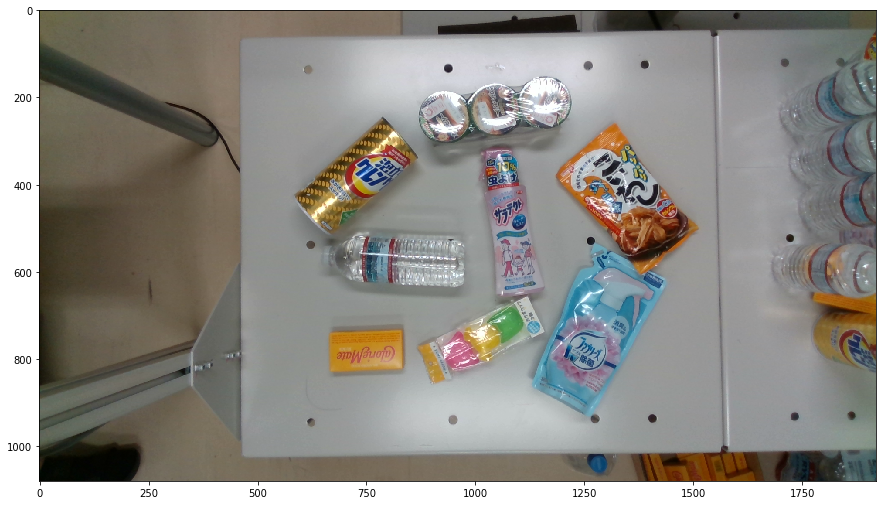

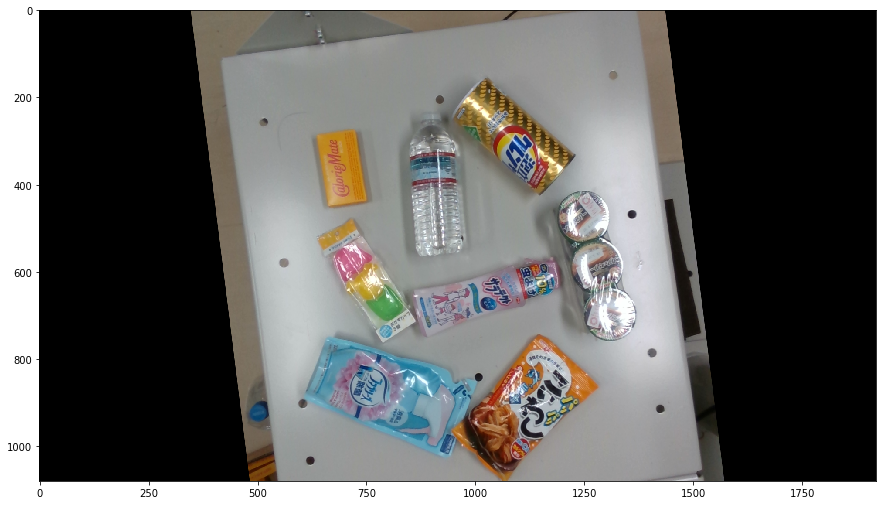

In [115]:
img_and_mask = np.append(img, mask, axis=2)
plt.imshow(img_and_mask[:,:,:3])
plt.show()
aug = iaa.Affine(rotate=(-180, 180))
#aug = iaa.LogContrast(gain=(0.6, 1.4))
#aug = iaa.GaussianBlur(sigma=(2.0))
test = aug.augment_image(img_and_mask)
test_img = test[:,:,:3]
test_mask = test[:,:,3:]
plt.imshow(test_img)
plt.show()


cv2.imwrite("test_augment.png", cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))

result = {}
result["test"] = {"filename":"test_augment.png", "file_attributes":{}, "size": 0}
regions = []
for i in range(test_mask.shape[-1]):
    attr = {}
    region_attributes = {"name": "test"}
    attr["region_attributes"] = region_attributes
    shape_attributes = {"name":"polyline"}
    all_points_x = []
    all_points_y = []
    
    tmp = test_mask[:,:,i]
    ret, thresh = cv2.threshold(tmp, 0.5, 1.0, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #print(contours[0])
    
    for i in range(len(contours[0])):
        all_points_x.append(int(contours[0][i][0][0]))
        all_points_y.append(int(contours[0][i][0][1]))
    shape_attributes["all_points_x"] = all_points_x
    shape_attributes["all_points_y"] = all_points_y
    
    attr["shape_attributes"] = shape_attributes
    regions.append(attr)
    #print(len(contours[0]))
    #plt.imshow(tmp, cmap="gray")
    #plt.show()
    
result["test"]["regions"] = regions

In [116]:
with open("label.json", 'w') as f:
    json.dump(result, f)